# Timeseries modelling with synthetic annotations

This notebook is an experimental one. It reads un-annotated covid-patient data and uses a saved annotation model (here, a naive bag-of-words) to provide synthetic domain and level labels for each patients' notes.

Most of this is redundant, but the plots for each patients' timeseries might be useful in future work.

In [52]:
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn
import statsmodels
import torch
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm

# Make graphics nice
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Set sensible defaults
sns.set()
sns.set_style("ticks")
sns.set_context('paper')

In [2]:
# Load in the training data
df = pd.read_csv('../data/timeseries_covid_train.tsv', sep='\t')
df.shape

(2485, 8)

In [3]:
df.patient_id.unique()

array([1824900, 4883738, 1825349, 1826096, 1826295, 3286406, 4099178,
       4174967, 1827925, 1828106, 1827855, 1828039, 7474489, 7391983,
       8227934, 1828811, 1829326, 1829557, 7704030, 1830607, 2974474,
       8293683, 1830514, 9426094, 1628243, 1831152, 4715790, 7594581,
       1834688, 1834711, 1834253,  957223, 4190540, 7651109, 4667364,
       6260057, 7843710, 8920715, 3850656, 8776560, 1845127, 1847708])

In [4]:
# Load in the current best sentence-level annotation model
with open('annotator_model_test.pkl', 'rb') as file:
    annotator = pickle.load(file)

In [ ]:
DOMAINS = ['STM', 'INS', 'BER', 'FAC']

def get_level_consensus(preds):
    # drop all the non-domains
    preds = preds[preds[:, 0] != 4]
    outs = []
    for i, d in enumerate(DOMAINS):
        if i in preds[:, 0]:
            outs.append(np.nanmedian(preds[preds[:, 0] == i], axis=0)[1])
        else:
            outs.append(np.nan)
    return outs

from nltk.tokenize import sent_tokenize

for d in DOMAINS:
    df[d] = np.nan
    
for nid in tqdm(df.note_id.unique()):
    text = sent_tokenize(df[df.note_id == nid].note.values[0].strip())
    preds = annotator.predict(text)
    outs = get_level_consensus(preds)
    df.loc[df.note_id == nid, DOMAINS] = outs
    
    
df.sample(5)

In [28]:
df[DOMAINS].describe()

,STM,INS,BER,FAC
count,0.0,284.000000,464.000000,914.000000
mean,NaN,2.536972,0.914871,1.004923
std,NaN,1.648816,0.985190,1.104718
min,NaN,0.000000,0.000000,0.000000
25%,NaN,1.000000,0.000000,0.000000
50%,NaN,4.000000,1.000000,1.000000
75%,NaN,4.000000,2.000000,2.000000
max,NaN,4.000000,4.000000,4.000000


In [55]:
df.shape

(2485, 12)

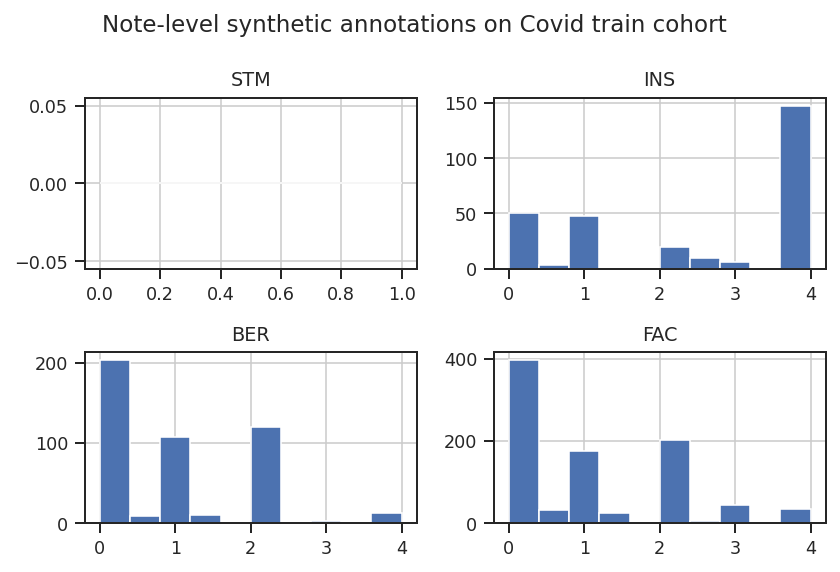

In [53]:
df[DOMAINS].hist()
plt.suptitle('Note-level synthetic annotations on Covid train cohort')
plt.tight_layout()

In [36]:
_df = df.groupby(['patient_id', 'date']).mean()[DOMAINS].reset_index()
_df

,patient_id,date,STM,INS,BER,FAC
0,957223,2020-04-11,NaN,NaN,0.50,NaN
1,957223,2020-04-12,NaN,2.500,NaN,0.90
2,957223,2020-04-13,NaN,4.000,1.00,0.75
3,957223,2020-04-14,NaN,4.000,1.00,1.50
4,957223,2020-04-15,NaN,3.125,0.25,1.00
...,...,...,...,...,...,...
666,9426094,2020-06-03,NaN,NaN,NaN,NaN
667,9426094,2020-07-03,NaN,NaN,NaN,NaN
668,9426094,2020-07-09,NaN,NaN,NaN,NaN
669,9426094,2020-09-07,NaN,0.000,2.00,0.00


/data/homedirs/gianluca/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


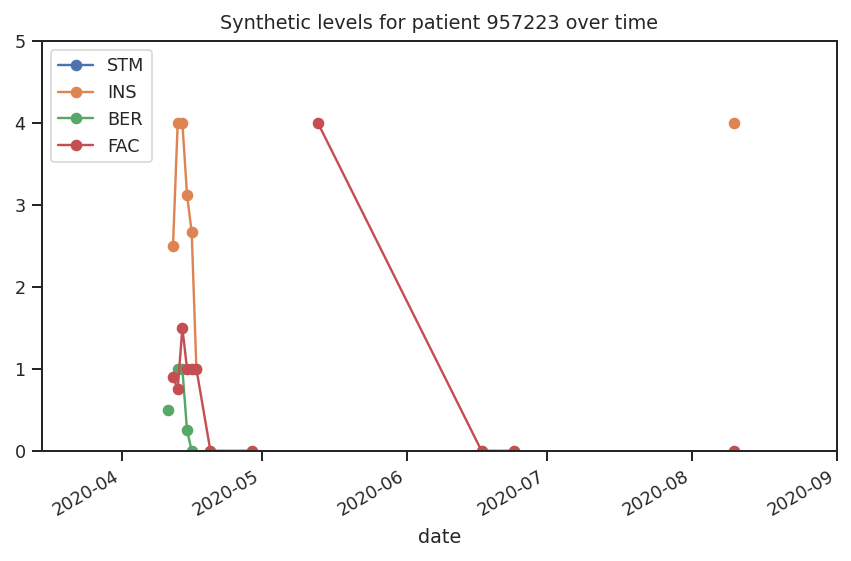

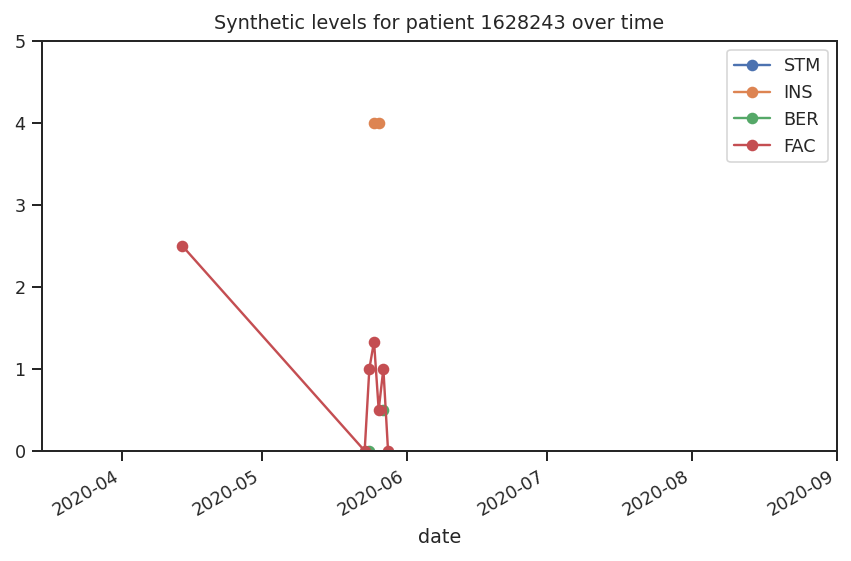

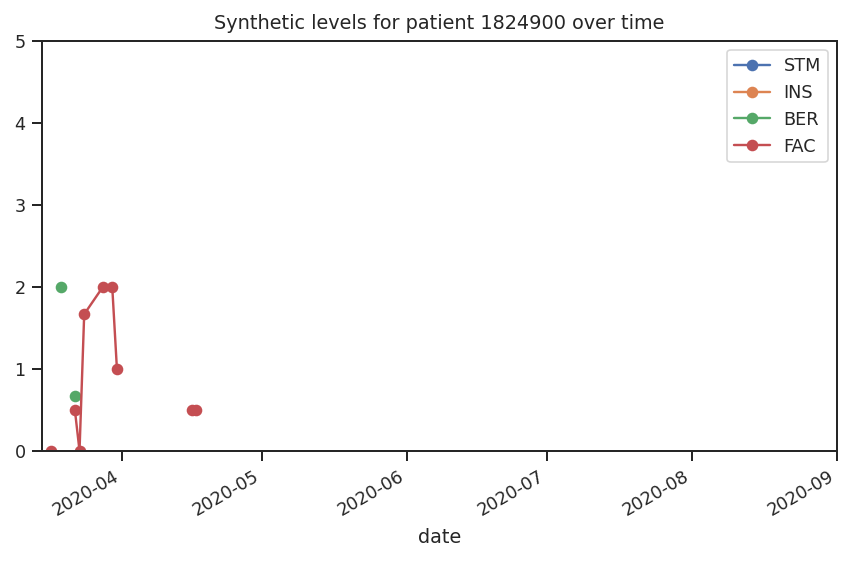

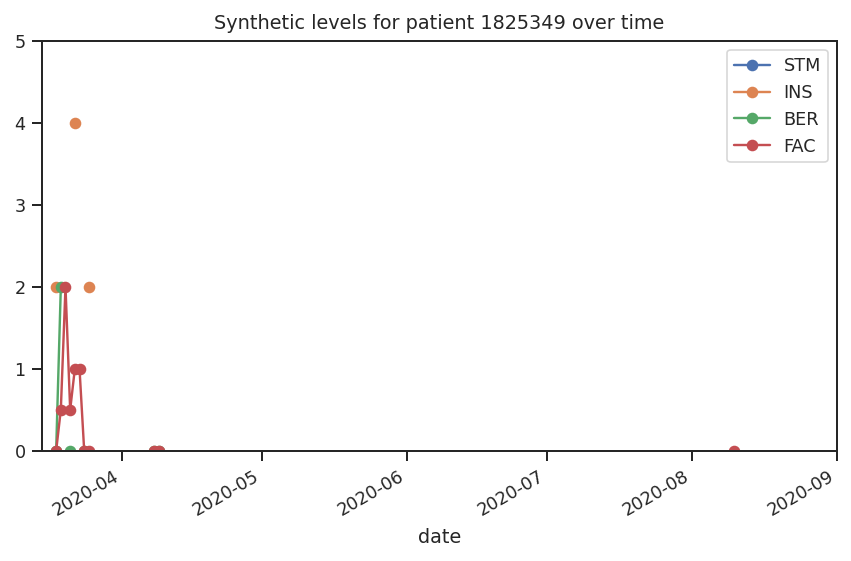

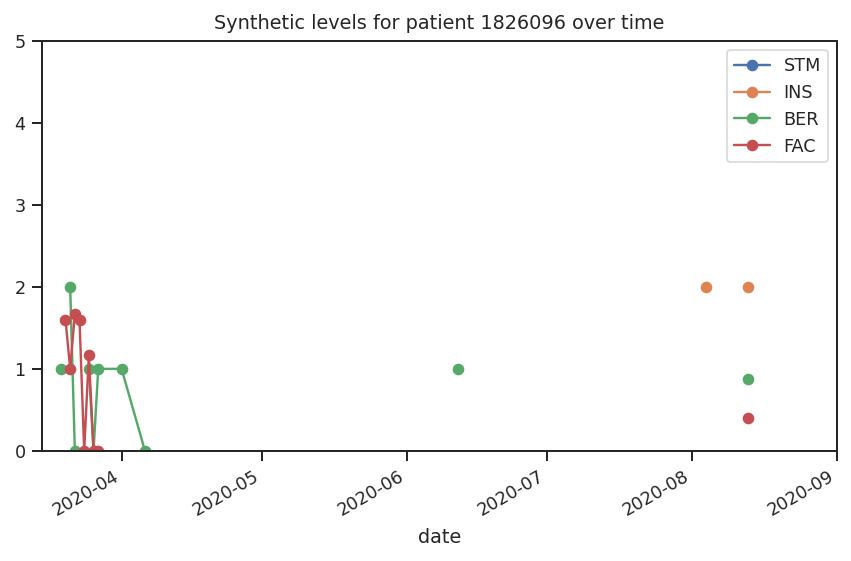

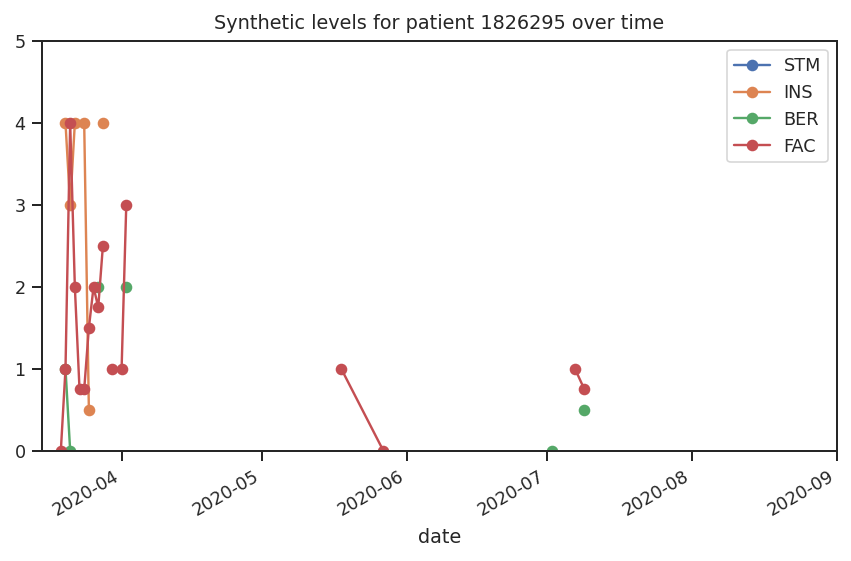

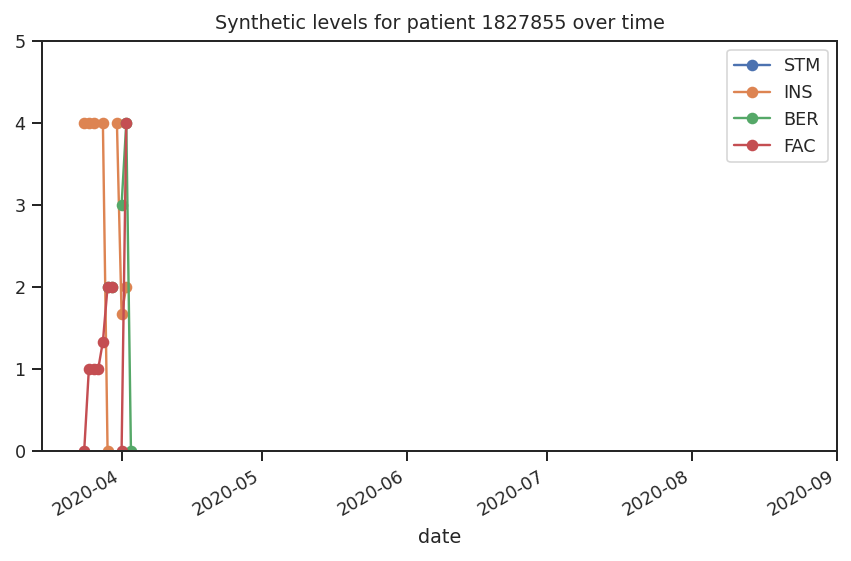

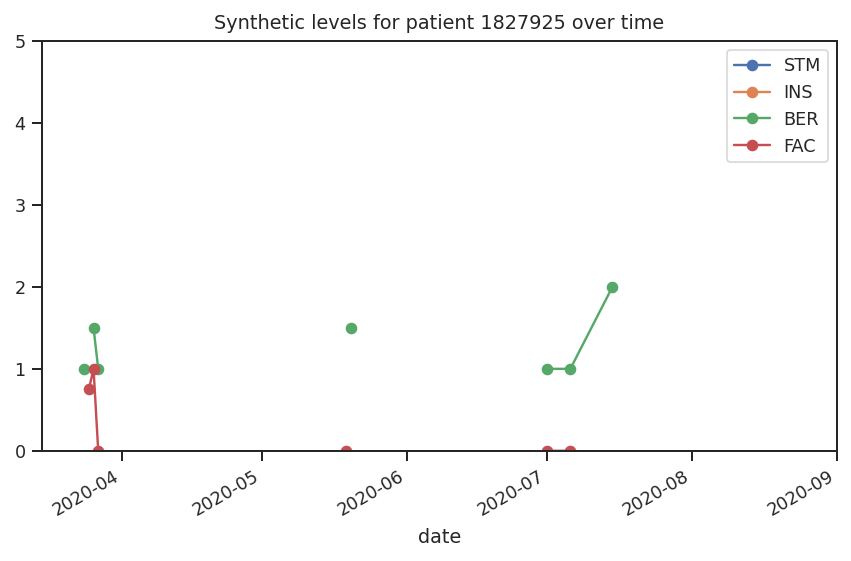

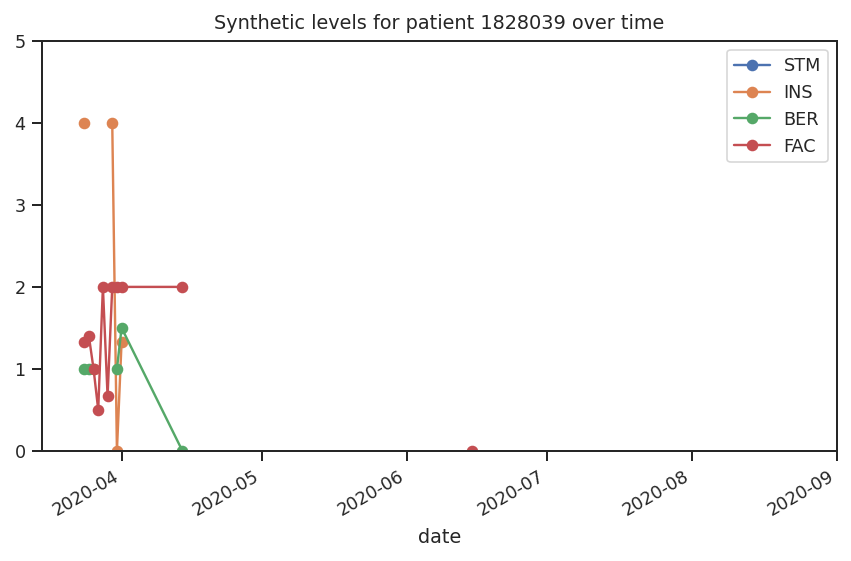

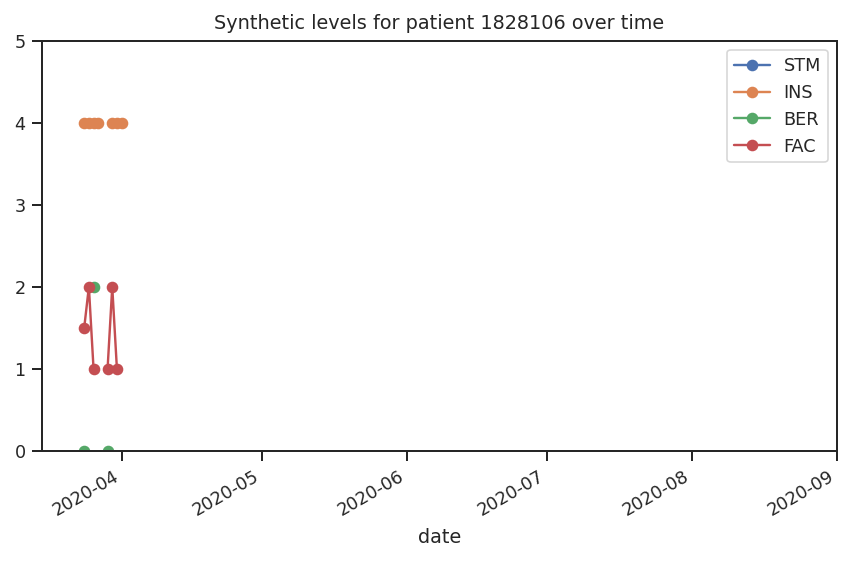

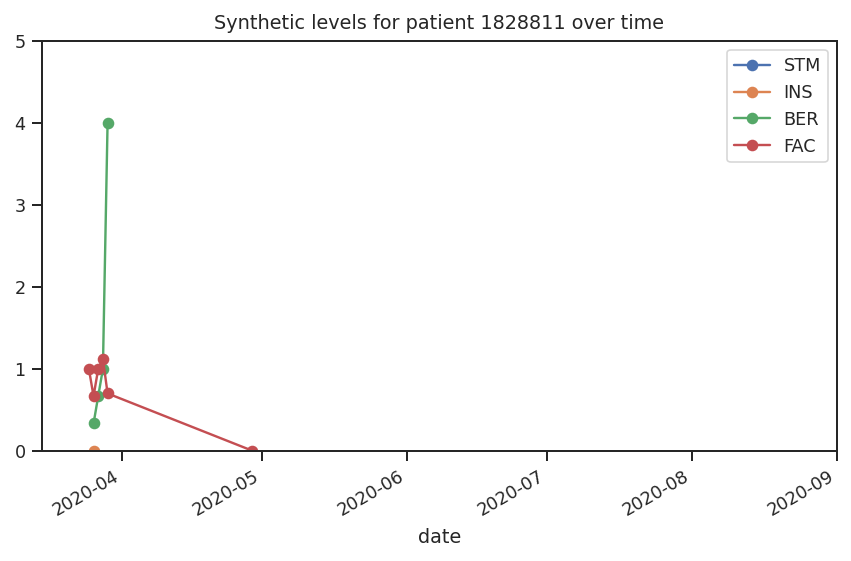

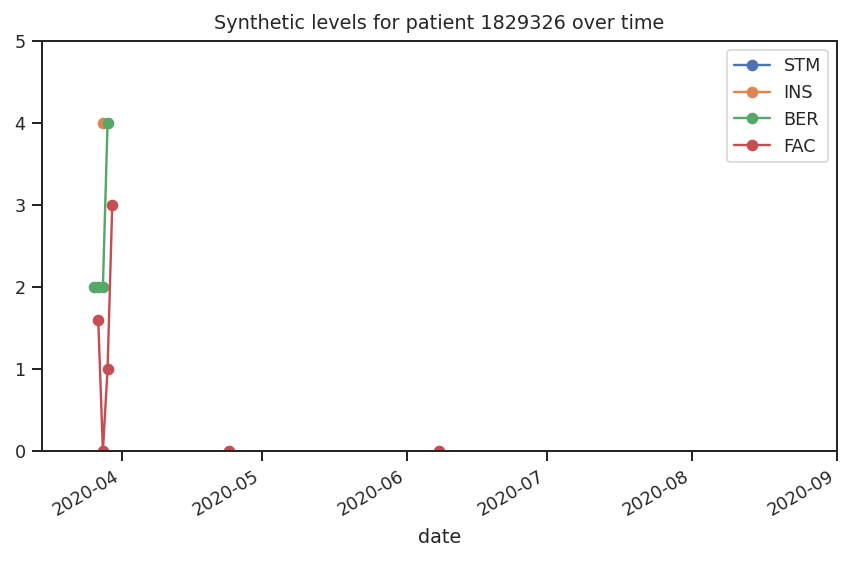

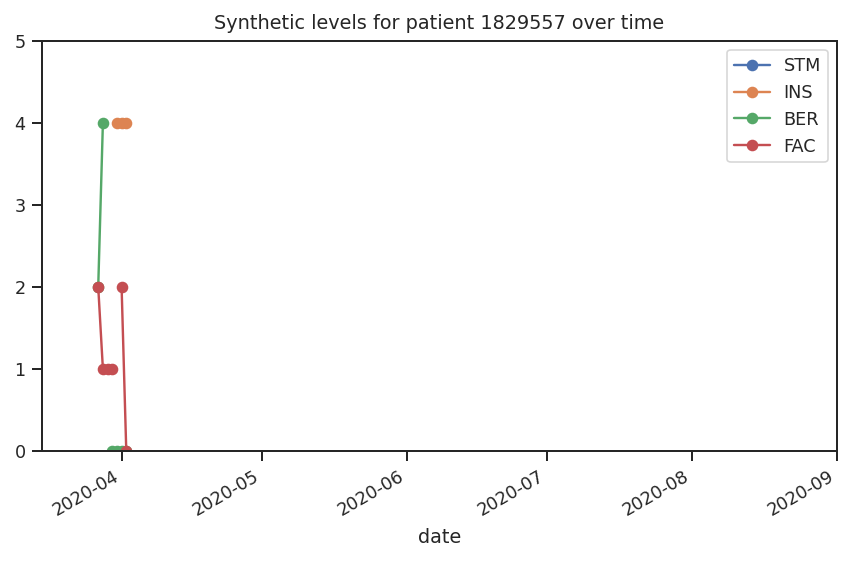

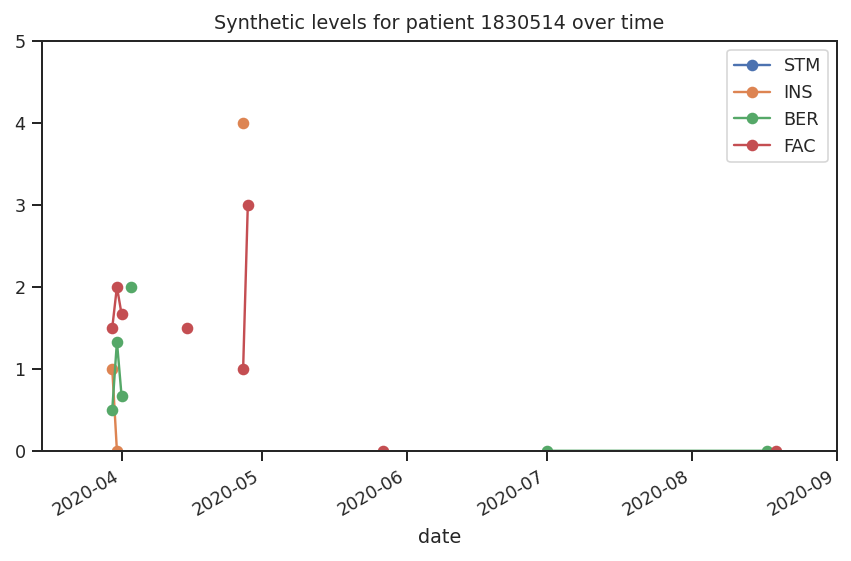

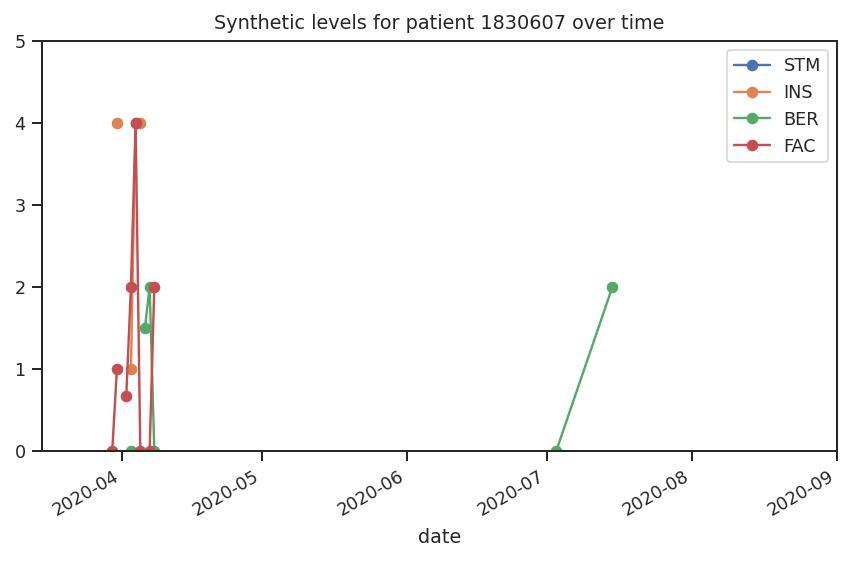

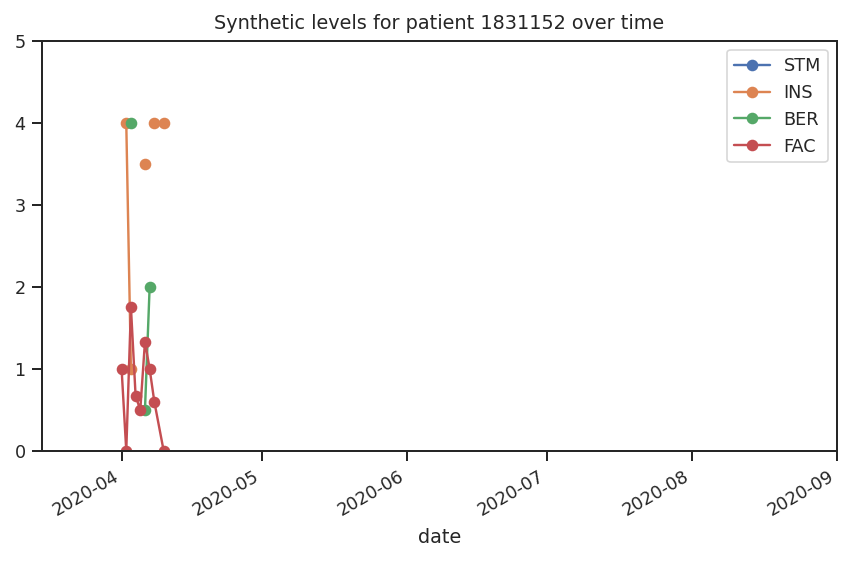

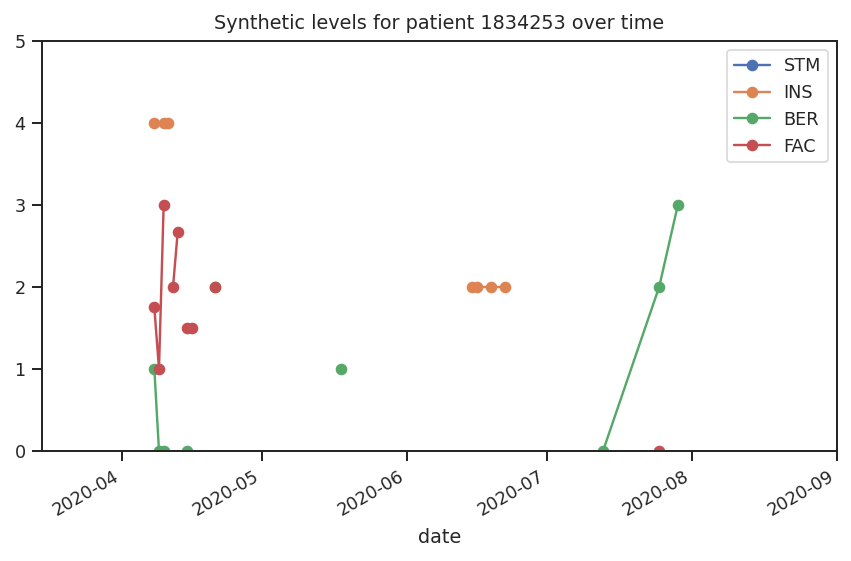

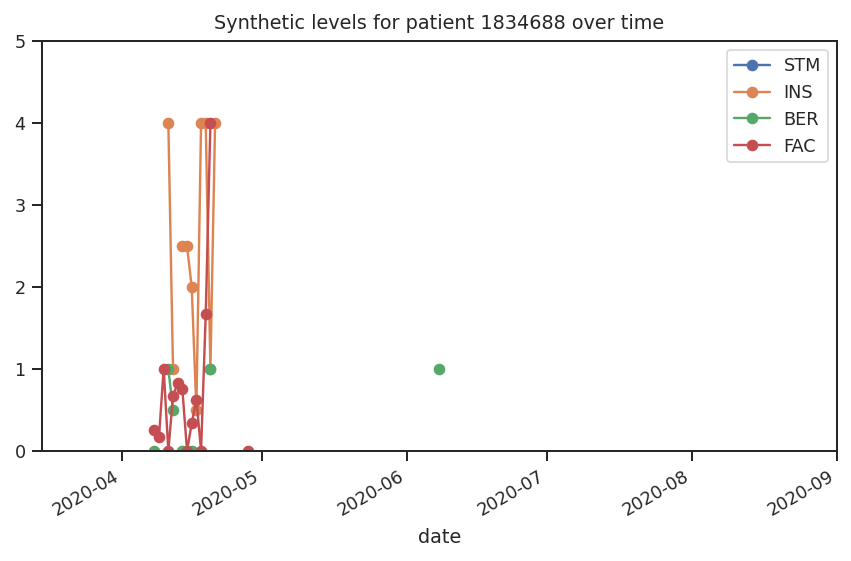

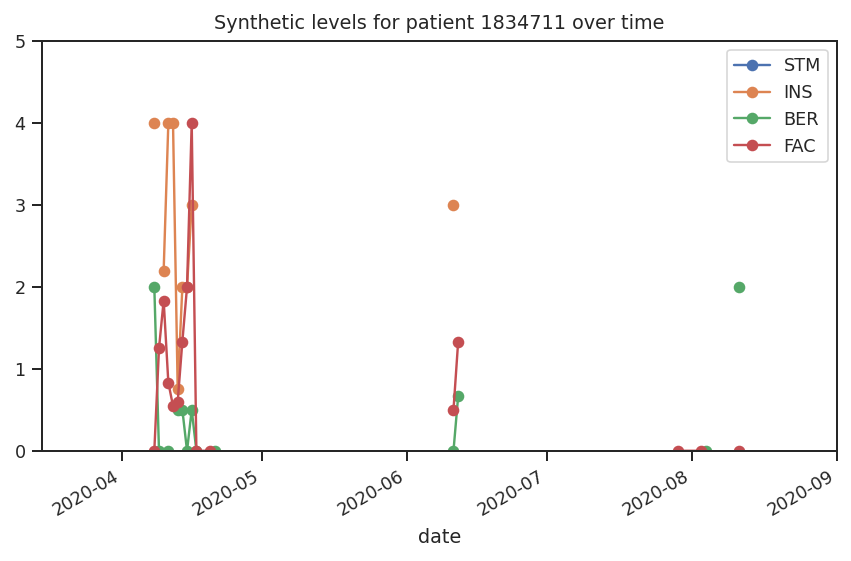

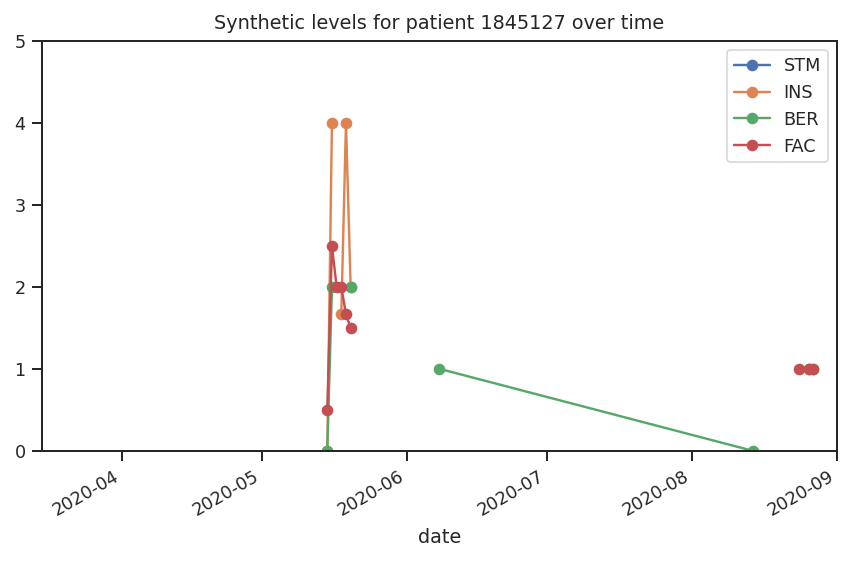

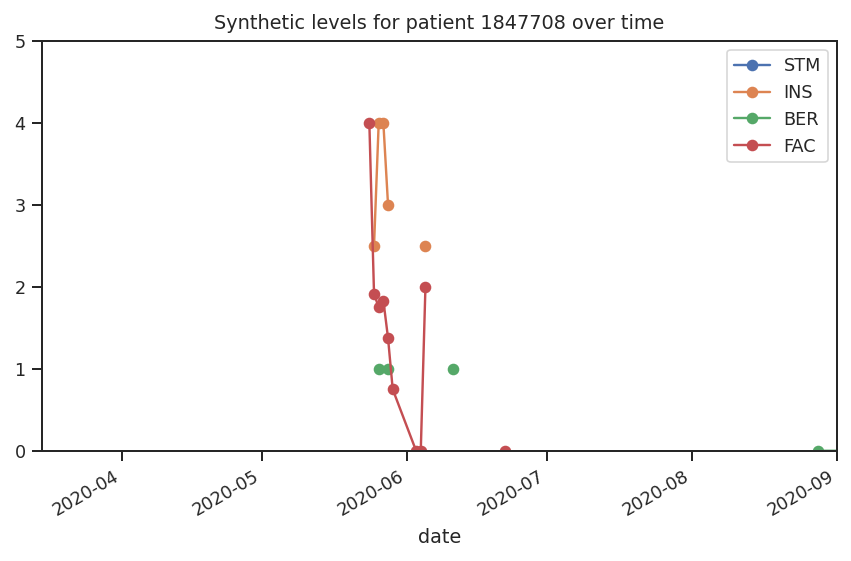

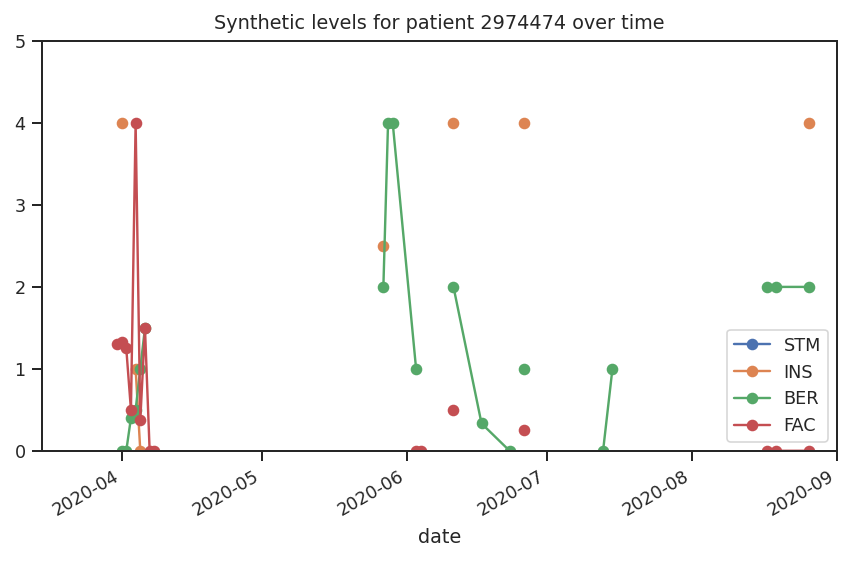

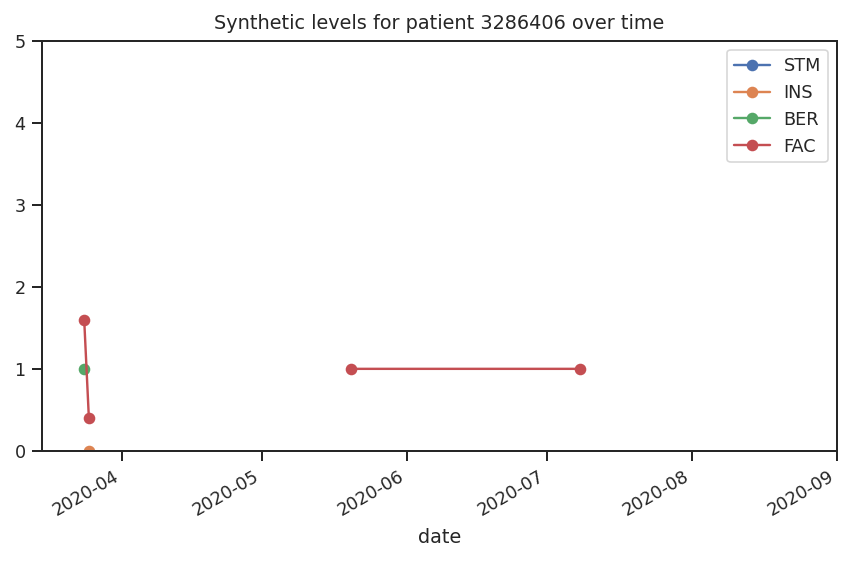

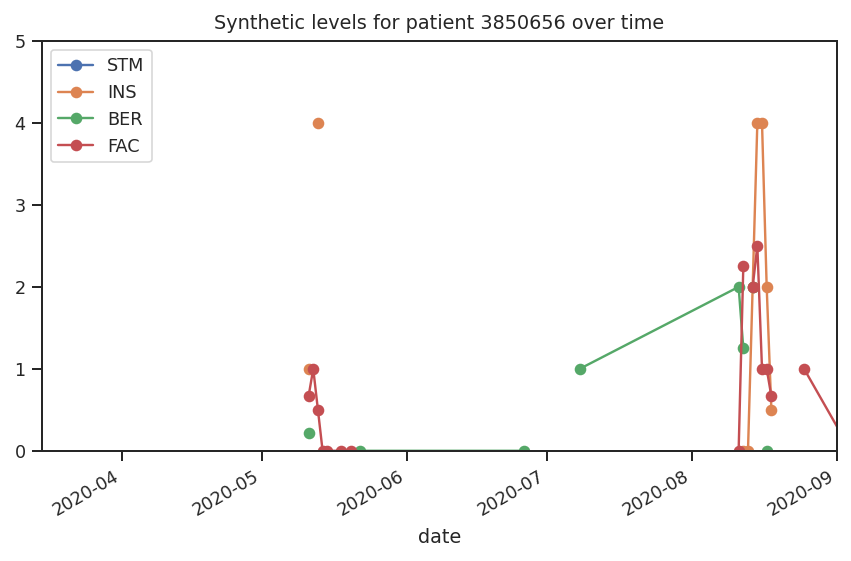

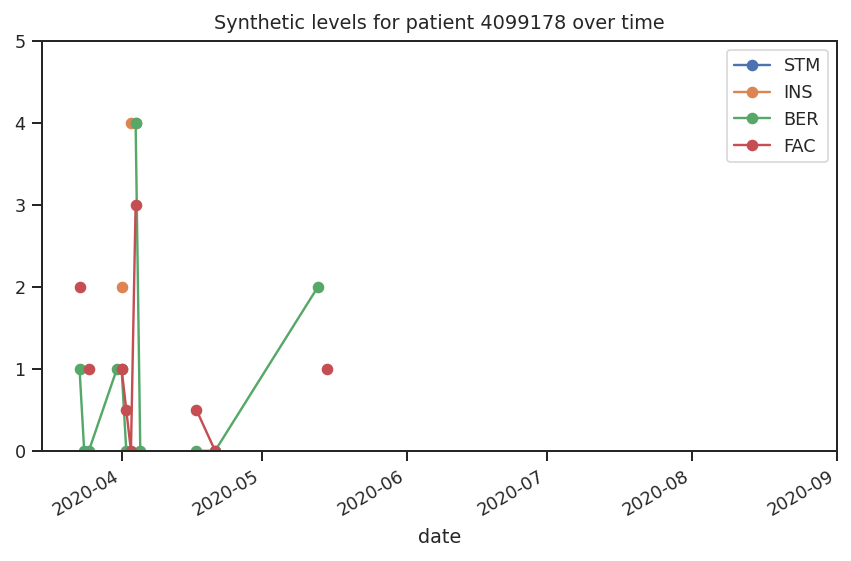

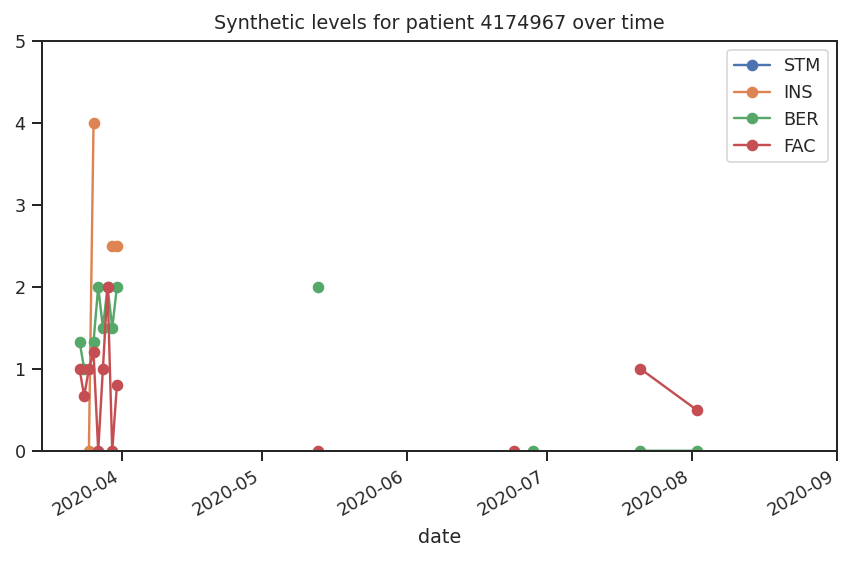

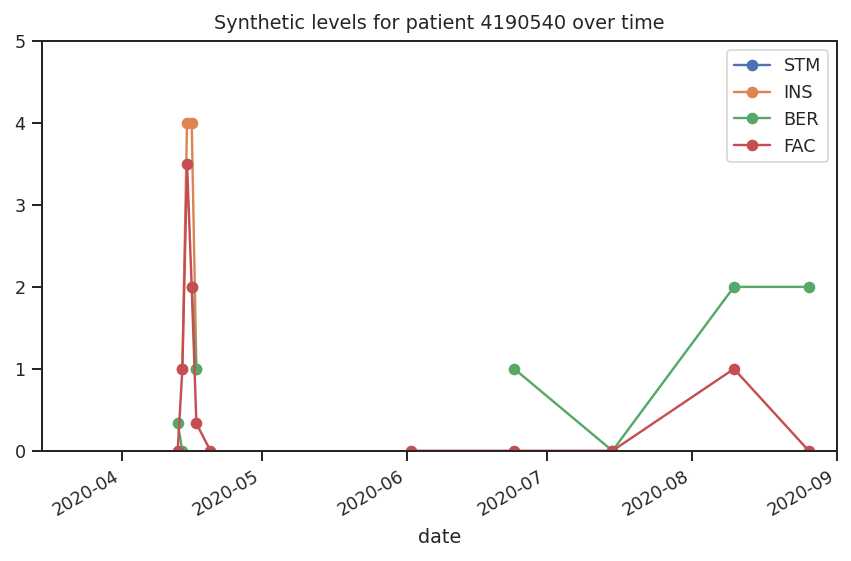

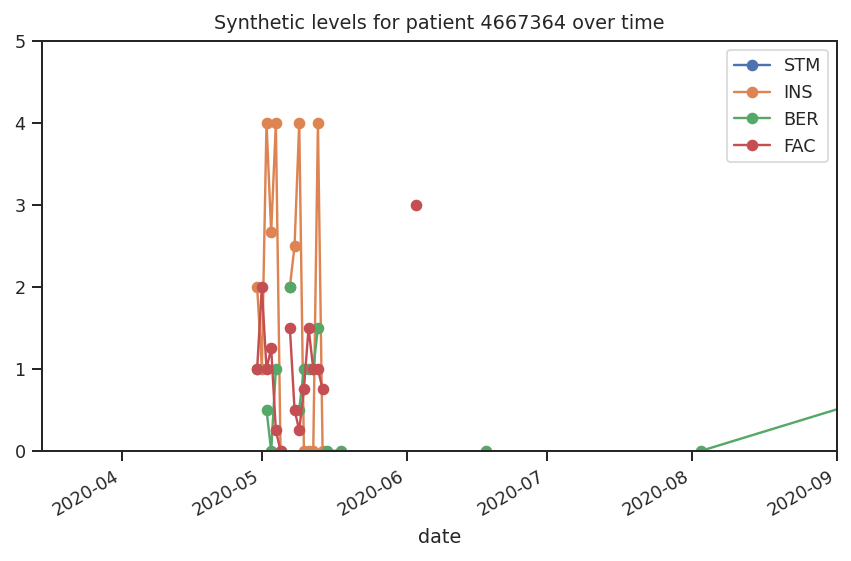

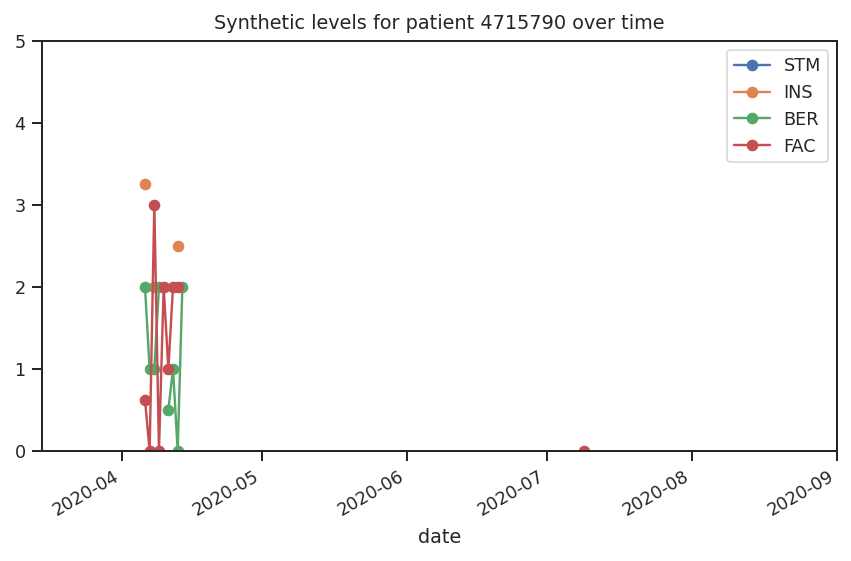

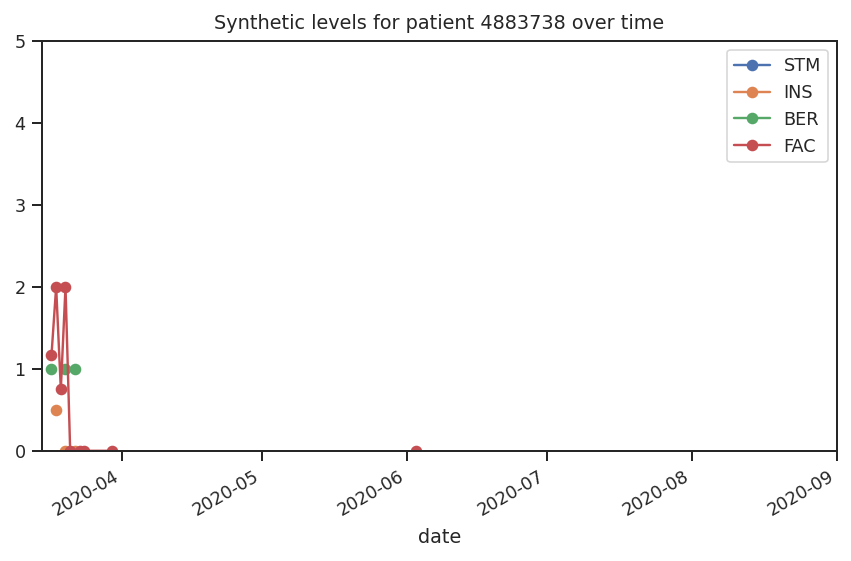

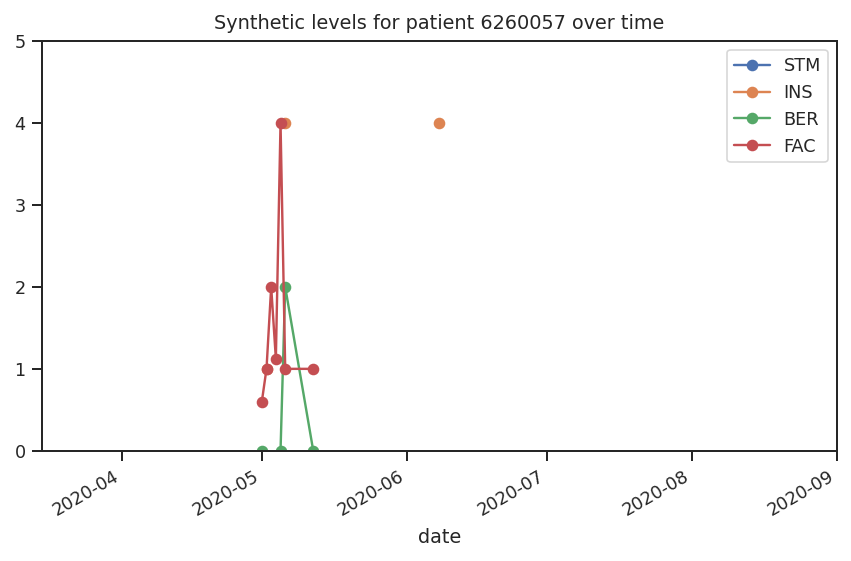

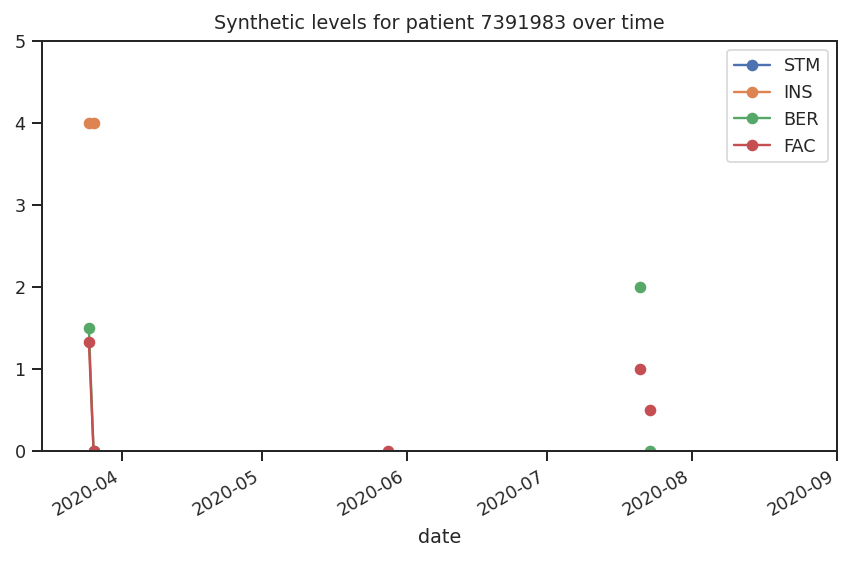

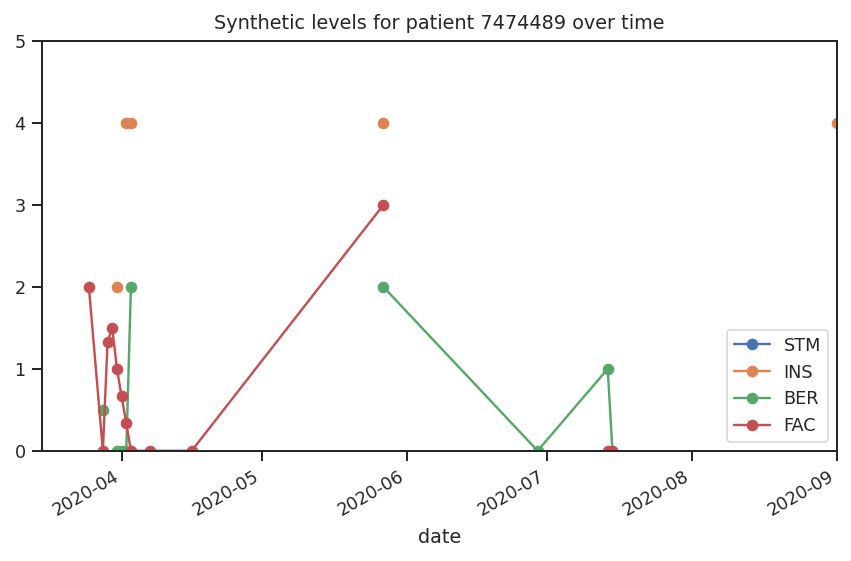

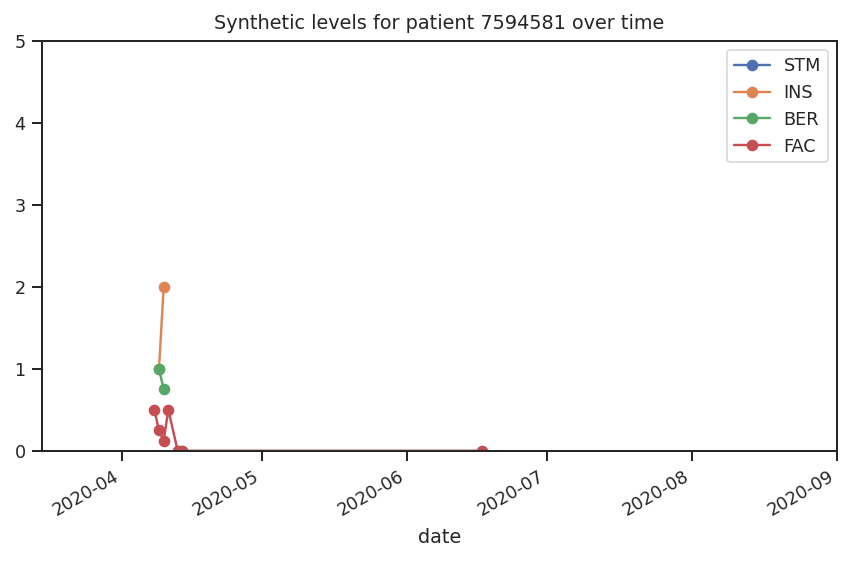

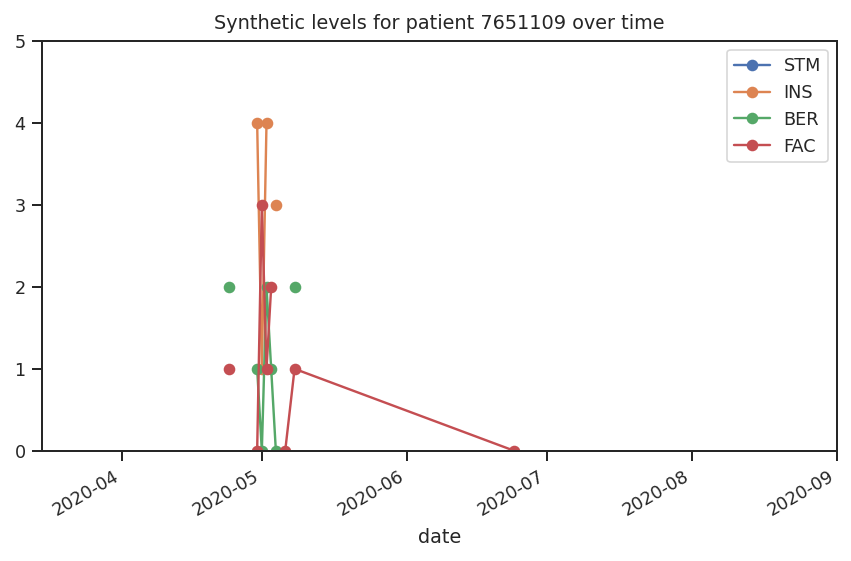

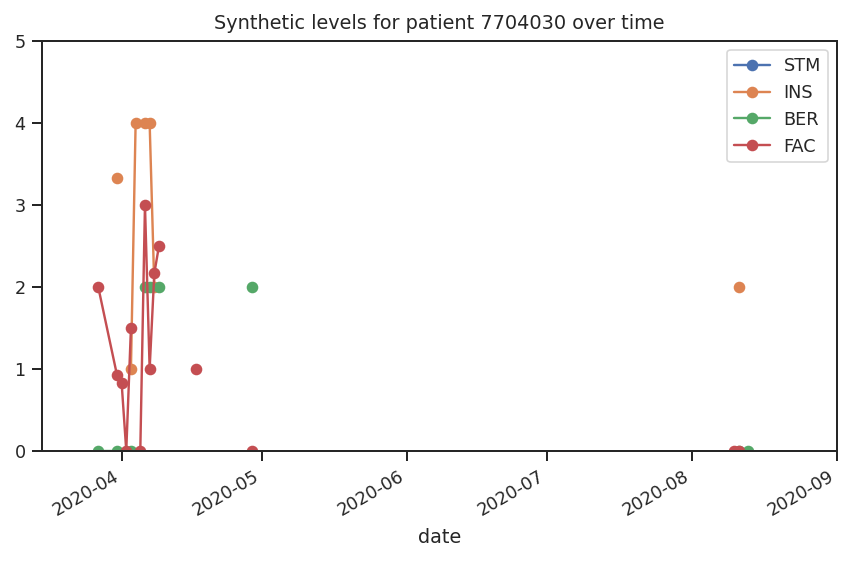

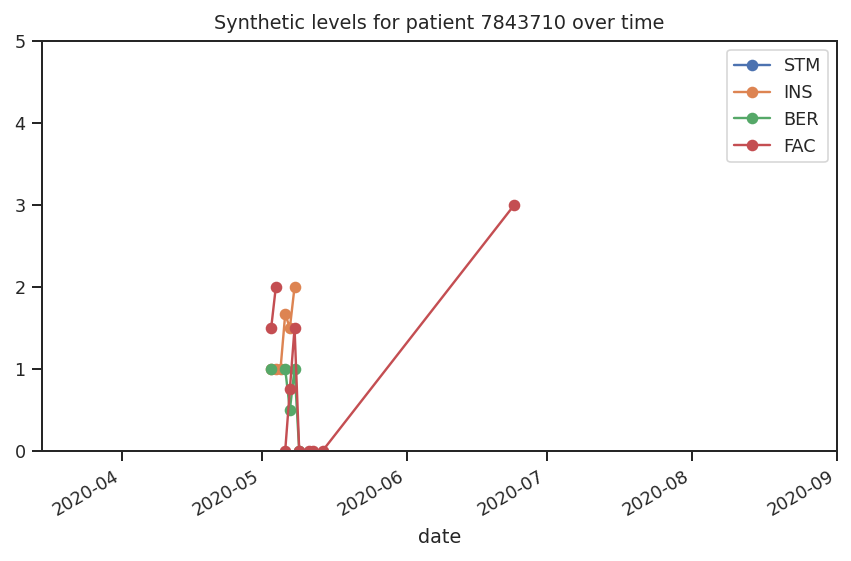

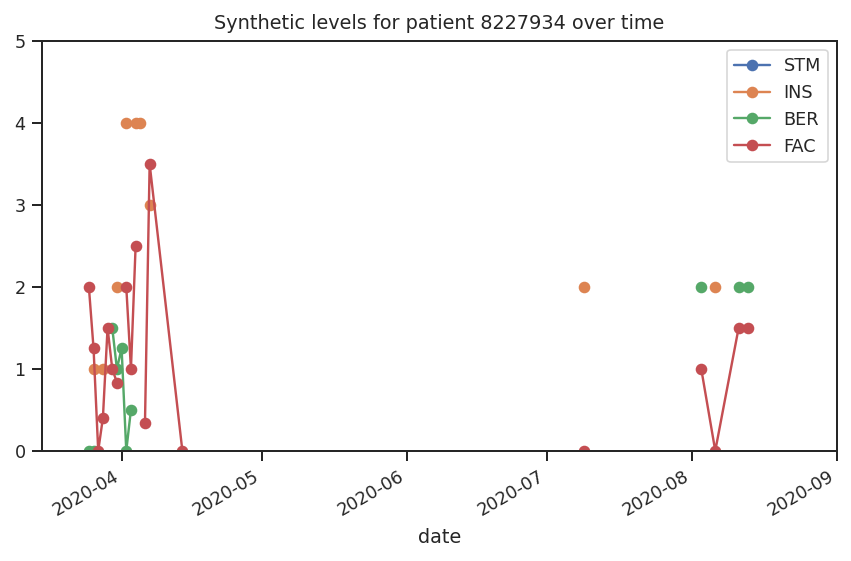

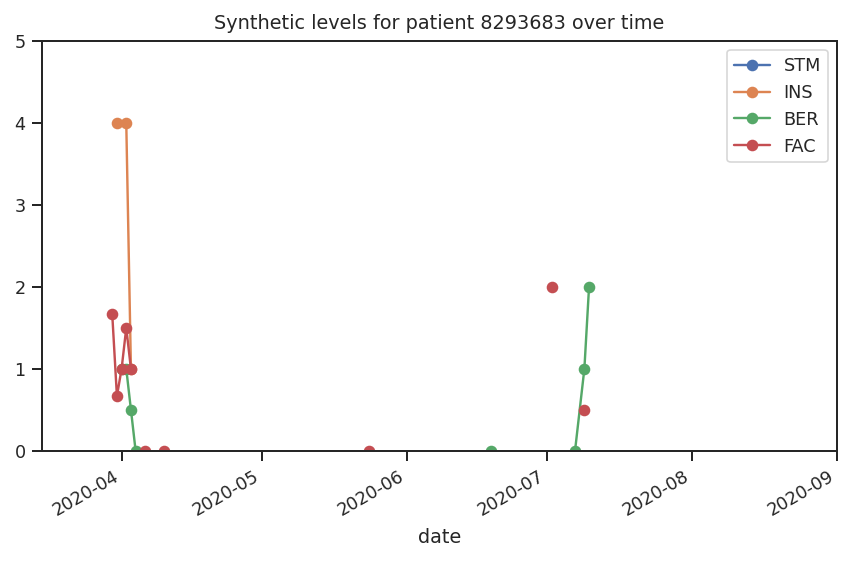

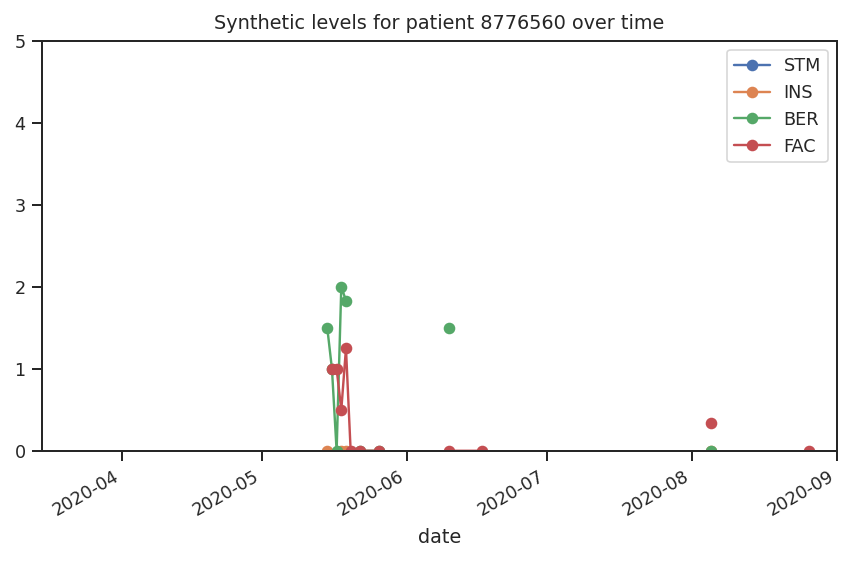

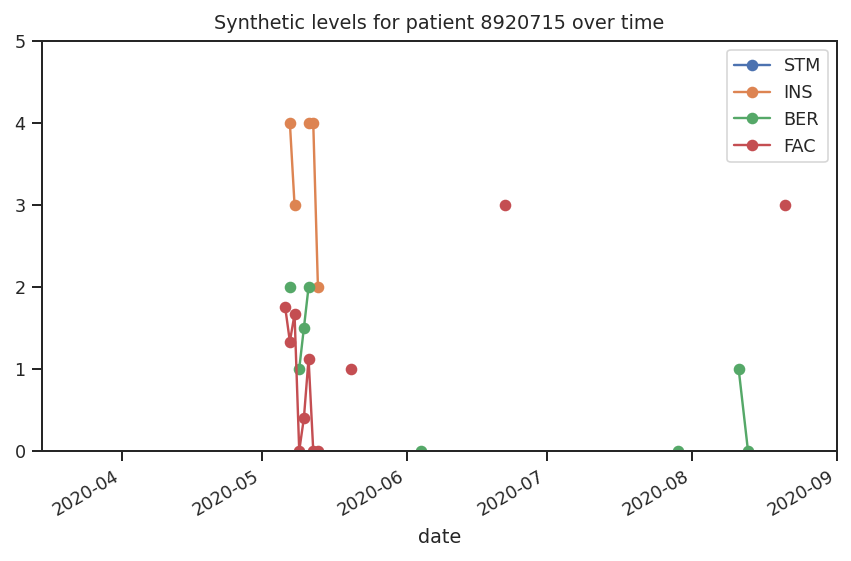

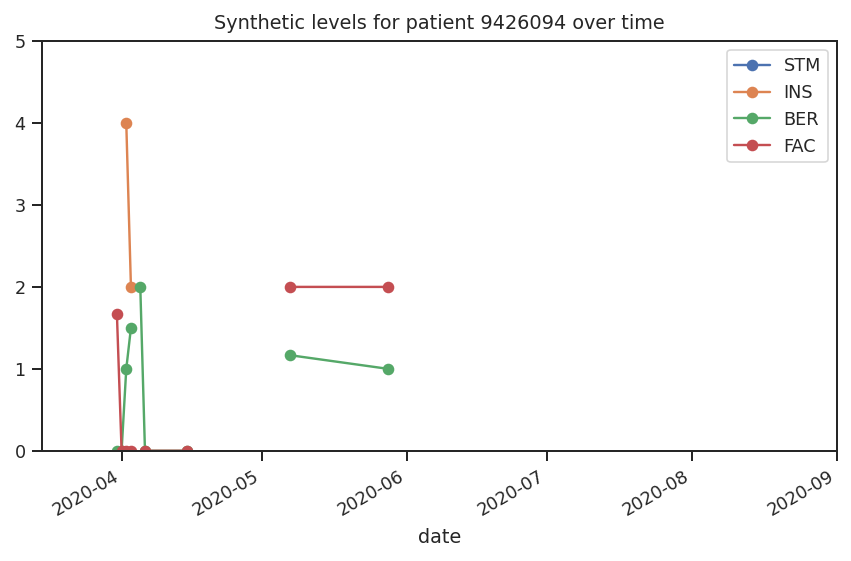

In [54]:
for pid in _df.patient_id.unique():
    data = _df[_df.patient_id == pid].sort_values(by='date', ascending=True)
    data['date'] = pd.to_datetime(data['date'])
    data.plot(x='date', y=DOMAINS, marker='o')
    plt.xlim('2020-3-15', '2020-09-01')
    plt.ylim(0, 5)
    plt.title(f"Synthetic levels for patient {pid} over time")
    plt.tight_layout()
    plt.show()